#   Tool Calling (Function Calling) + 에이전트(Agent) 개념

---

## 환경 설정 및 준비

`(1) Env 환경변수`

In [ ]:
from dotenv import load_dotenv
load_dotenv()

`(2) 기본 라이브러리`

In [ ]:
import os
from glob import glob

from pprint import pprint
import json

`(3) Langsmith tracing 설정`

In [ ]:
# Langsmith tracing 여부를 확인 (true: langsmith 추척 활성화, false: langsmith 추척 비활성화)
import os
print(os.getenv('LANGSMITH_TRACING'))

---

## **Tool Calling**

- **Tool Calling**은 LLM이 외부 시스템과 상호작용하기 위한 **함수 호출 메커니즘**

- LLM은 정의된 도구나 함수를 통해 **외부 시스템과 통신**하고 작업을 수행

- **Tool calling**은 모델이 시스템과 직접 상호작용할 수 있게 하는 기능

- **구조화된 출력**을 통해 API나 데이터베이스와 같은 시스템 요구사항 충족

- **스키마 기반 응답**으로 시스템 간 효율적 통신 가능

- OpenAI는 2023년 말부터 "Function Calling"을 "Tool Calling"으로 명칭을 변경했습니다. 두 용어는 실질적으로 동일한 개념을 의미합니다.


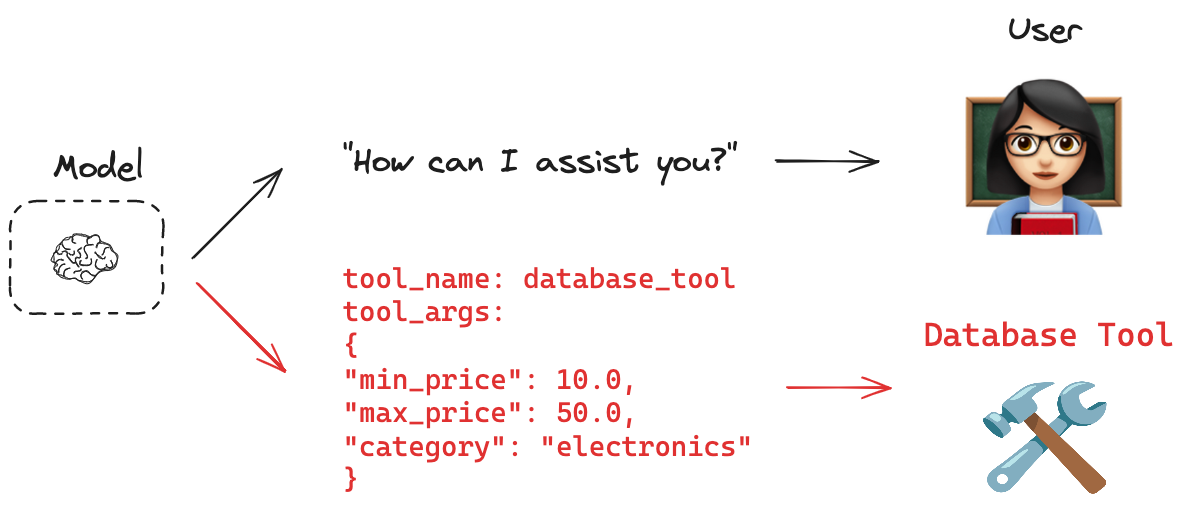

### Tool Calling vs Function Calling 비교

| 구분 | Tool Calling | Function Calling |
|------|-------------|------------------|
| **명칭** | LangChain/최신 API 표준 용어 | OpenAI 초기 API 용어 |
| **범위** | 다양한 도구 유형 지원 | 함수에 한정 |
| **표준화** | 공급자 독립적 인터페이스 | OpenAI 특화 |
| **사용 시점** | LangChain 생태계 전반 | OpenAI API 직접 호출 시 |

---

### 1. **Tool Creation** (`@tool` 데코레이터 사용)

- **@tool 데코레이터**로 함수에 스키마 정보 추가

- **함수와 스키마** 간 자동 연결로 도구 생성

`(1) 간단한 날씨 예제`

In [ ]:
from langchain_core.tools import tool
from typing import Literal

@tool
def get_weather(city: Literal["서울", "부산", "대구", "인천", "광주"]):
    """한국 주요 도시의 날씨 정보를 가져옵니다."""
    weather_data = {
        "서울": "맑음",
        "부산": "흐림",
        "대구": "맑음",
        "인천": "비",
        "광주": "구름많음"
    }
    
    if city in weather_data:
        return f"{city} 날씨는 {weather_data[city]}"
    else:
        raise AssertionError("지원하지 않는 도시입니다")

In [ ]:
# 도구 실행
get_weather.invoke("부산")

`(2) DB 검색 예제`

In [ ]:
# 벡터 저장소 로드 
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

chroma_db = Chroma(
    collection_name="hybrid_search_db",
    embedding_function=embeddings,
    persist_directory="./local_chroma_db",
)

print(chroma_db._collection.count())

In [ ]:
# 검색기 지정하여 테스트 
chroma_k_retriever = chroma_db.as_retriever(
    search_kwargs={"k": 2},
)

query = "리비안은 언제 사업을 시작했나요?"
retrieved_docs = chroma_k_retriever.invoke(query)

print(f"쿼리: {query}")
print("검색 결과:")
for doc in retrieved_docs:
    print(f"- {doc.page_content} [출처: {doc.metadata['source']}]")

In [ ]:
# DB 검색하는 사용자 정의 도구 생성
from langchain_core.tools import tool

@tool
def search_db(query: str):
    """리비안, 테슬라 회사에 대한 정보를 관련 데이터베이스에서 검색합니다."""
    return chroma_k_retriever.invoke(query)

# 도구 실행
search_db.invoke("리비안은 언제 사업을 시작했나요?")

---

### 2. **Tool Binding** (모델에 Tool 연결)

- **모델-도구 연결**로 입력 스키마 자동 인식

- **스키마 기반 검증**으로 올바른 입력 보장

- `bind_tools()` 동작 원리

    1. **스키마 추출**: `@tool` 데코레이터가 함수의 타입 힌트와 독스트링에서 JSON Schema 생성
    2. **모델 전달**: 생성된 스키마가 LLM API 요청에 포함됨
    3. **응답 생성**: LLM이 스키마에 맞는 구조화된 Tool Call 응답 생성

    ```
    [사용자 입력] → [LLM + 도구 스키마] → [Tool Call 응답] → [도구 실행]
    ```

In [ ]:
from langchain_openai import ChatOpenAI

# 모델
model = ChatOpenAI(model="gpt-4.1-nano",temperature=0)

# 도구 목록
tools = [get_weather, search_db]

# 도구를 모델에 바인딩 (bind_tools 메소드 사용)
model_with_tools = model.bind_tools(tools)

# 사용자 쿼리를 모델에 전달하여 도구를 호출
result = model_with_tools.invoke("서울 날씨 어때?")

result

In [ ]:
print(result.tool_calls)

---

### 3. **Tool Calling** (모델이 Tool을 사용하는 경우)

- **스키마 기반 응답** 생성으로 정확한 입력 형식 준수

- **자동 유효성 검증**으로 오류 방지

- **구조화된 출력** 생성으로 시스템 호환성 보장

In [ ]:
# 결과 출력
for k in dict(result).keys():
    print(f"{k}: ")
    print(dict(result)[k])
    print("-"*100)

In [ ]:
# tool_calls 출력
pprint(result.tool_calls)

In [ ]:
# DB 검색 도구 호출
search_result = model_with_tools.invoke("리비안은 언제 사업을 시작했나요?")

# 검색 결과 출력
print("검색 결과:")
for k in dict(search_result).keys():
    print(f"{k}: ")
    print(dict(search_result)[k])
    print("-"*100)

# tool_calls 출력
pprint(search_result.tool_calls)

---

### 4. **Tool Execution**  (Tool이 호출된 경우 실행)

- **인자 기반 실행**으로 도구 기능 수행

- **모델 제공 파라미터**로 자동화된 실행

- **실행 결과** 처리 및 반환

`(1) 함수의 인자를 직접 전달`

In [ ]:
# 함수의 인자를 직접 전달하는 방식으로 실행 -> 도구를 직접 호출
result.tool_calls[0]['args']

In [ ]:
get_weather.invoke(result.tool_calls[0]['args'])

In [ ]:
search_result.tool_calls[0]['args']

In [ ]:
search_db.invoke(search_result.tool_calls[0]['args'])

`(2) ToolCall 객체를 전달` : **ToolMessage**의 역할

- 도구 실행 결과를 LLM에게 전달하는 **표준화된 메시지 형식**
- `tool_call_id`로 어떤 Tool Call에 대한 응답인지 추적
- **에이전트 루프**에서 LLM이 다음 행동을 결정하는 데 사용됨

    | 속성 | 설명 |
    |------|------|
    | `content` | 도구 실행 결과 (문자열) |
    | `name` | 호출된 도구 이름 |
    | `tool_call_id` | 원본 Tool Call의 고유 ID |

In [ ]:
# ToolCall 객체를 전달 전달하는 방식으로 실행 -> ToolMessage 객체를 반환
get_weather.invoke(result.tool_calls[0])

In [ ]:
search_db.invoke(search_result.tool_calls[0])

---

###  Tool Calling 사용 시 **고려사항**

- **모델 호환성**이 Tool Calling 성능에 직접 영향

- **명확한 도구 정의**가 모델의 이해도와 활용도 향상

- **단순한 기능**의 도구가 더 효과적으로 작동

- **과다한 도구**는 모델 성능 저하 유발

---

## **Agent**

- **LLM(대규모 언어 모델)** 을 의사결정 엔진으로 사용하여 작업을 수행하는 시스템

- 모델은 입력된 데이터를 분석하여 **맥락에 맞는 의사결정**을 수행

- 시스템은 사용자의 요청을 이해하고 **적절한 해결책**을 제시

- 복잡한 작업을 자동화하여 **업무 효율성**을 높일 수 있음 

### 1. **최신 에이전트 생성 (create_agent)**

- **create_agent** 함수는 LangChain의 최신 표준 에이전트 생성 방식입니다.

- 내부적으로 **LangGraph**를 사용하여 컴파일된 그래프(CompiledGraph)를 반환합니다.

- 기존 **AgentExecutor**의 기능을 포함하면서도, 더 강력한 **상태 관리**와 **스트리밍** 기능을 제공합니다.

- **Legacy vs Modern 비교**

    | 항목 | AgentExecutor (Legacy) | create_agent (Modern) |
    |------|------------------------|-----------------------|
    | **기반 기술** | 기본 Chain | **LangGraph** |
    | **유연성** | 제한적 | **높음** (커스텀 그래프 확장 가능) |
    | **상태 관리** | 기본적 | **고급** (TypedDict, Checkpointing) |
    | **인터페이스** | `invoke`, `stream` | `invoke`, `stream` (동일) |
    | **권장 사용** | 간단한 프로토타입 | **모든 프로젝트** (표준) |

`(1) 추가 도구 정의`

- **@tool 데코레이터**를 사용해 계산(파이썬 코드 실행) 기능을 가진 **커스텀 도구를 정의**

- 데코레이터를 통해 함수가 **Tool Calling 시스템에 등록**되어 LLM이 호출 가능

In [ ]:
@tool
def calculate(expression: str) -> float:
    """수학 계산을 수행합니다."""
    return eval(expression)

In [ ]:
# 도구 실행 
calculate.invoke("3+2")

`(2) LLM 지정`

- **ChatGPT 모델**이 에이전트의 **핵심 추론 엔진**으로 사용됨

- 모델은 사용자 입력을 분석하고 **적절한 도구를 선택**하여 작업 수행

In [ ]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4.1-mini",temperature=0)

`(3) Agent (에이전트) 생성`

- **에이전트**는 LLM과 도구를 **통합**하여 복잡한 작업을 수행하는 시스템

- 프롬프트 템플릿을 기반으로 **사용자 요청을 해석**하고 적절한 도구 선택

- 도구 실행 결과를 분석하여 **최종 응답을 생성**하는 워크플로우 구현

In [ ]:
from langchain.agents import create_agent

# 도구 목록 생성 
tools = [get_weather, search_db, calculate]

# 에이전트 생성
# System Prompt는 직접 문자열로 전달
system_prompt = "당신은 사용자의 요청을 처리하는 AI Assistant입니다."
agent = create_agent(llm, tools, system_prompt=system_prompt)

`(4) Agent Runtime (에이전트 런타임) 생성`

- **create_agent** 함수는 LangGraph 기반의 **컴파일된 그래프(CompiledGraph)** 를 반환합니다.

- 이는 기존 **AgentExecutor**의 역할을 대체하며, 더 유연한 **상태 관리**와 **스트리밍** 기능을 제공합니다.

- 반환된 객체는 `invoke` 메서드를 통해 바로 실행 가능합니다.

In [ ]:
# 에이전트 실행 (LangGraph 기반 입력 포맷: messages)
response = agent.invoke(
    {"messages": [("user", "서울의 날씨는 어떤가요?")]}
)

In [ ]:
# 에이전트 실행 결과 출력
pprint(response['messages'])

In [ ]:
# 에이전트 실행
response = agent.invoke(
    {"messages": [("user", "32 더하기 18은 얼마인가요?")]}
)

In [ ]:
# 에이전트 실행 결과 출력
pprint(response['messages'])

---

### 2. **LangGraph** 

- **LangGraph**는 LangChain의 확장 도구로 **고급 에이전트 개발**을 지원

- **그래프 기반 워크플로우**를 통해 복잡한 에이전트 로직을 구현할 수 있음 

- 상태 관리와 **타입 안전성**을 통해 안정적인 에이전트 실행을 보장

- AgentExecutor보다 더 **유연한 사용자 정의**가 가능함 

`(1) 도구 실행 에이전트 정의`

- LangGraph의 **react agent executor**는 메시지 목록으로 상태를 관리

- 에이전트의 출력에 **도구 호출**이 없을 때까지 메시지를 계속 처리함

- 시작 시 **초기 메시지 목록**을 입력으로 사용

- 실행 결과로 전체 **대화 기록**을 포함한 그래프 상태를 반환

- **메시지 기반 상태** 관리를 통해 에이전트의 실행 흐름을 체계적으로 제어

In [ ]:
from langgraph.prebuilt import create_react_agent

# 도구 목록 생성 
tools = [get_weather, search_db, calculate]

# 도구 실행 에인전트 생성
langgraph_agent_executor = create_react_agent(model, tools)

`(2) 에이전트 실행`

In [ ]:
# 에이전트 실행
results = langgraph_agent_executor.invoke(
    {"messages": [("human", "32 곱하기 18은 얼마인가요?")]}
)

# 에이전트 실행 결과 출력
pprint(results)

---

## **에러 핸들링 (Error Handling)**

Tool Calling에서 안정적인 에러 처리는 프로덕션 환경에서 필수적입니다.

In [ ]:
from langchain_core.tools import tool, ToolException

@tool
def safe_calculate(expression: str) -> float:
    """
    수학 계산을 안전하게 수행합니다.
    에러 발생 시 LLM에게 친화적인 메시지를 반환합니다.
    """
    try:
        # 위험한 함수 제거 (보안)
        allowed_chars = set('0123456789+-*/().% ')
        if not all(c in allowed_chars for c in expression):
            raise ToolException("허용되지 않는 문자가 포함되어 있습니다. 숫자와 기본 연산자만 사용하세요.")
        
        result = eval(expression)
        return result
    except ZeroDivisionError:
        raise ToolException("0으로 나눌 수 없습니다. 다른 표현식을 사용해주세요.")
    except SyntaxError:
        raise ToolException("수식 형식이 올바르지 않습니다. 예: '3 + 5', '10 * 2'")
    except Exception as e:
        raise ToolException(f"계산 중 오류 발생: {str(e)}")

# 테스트
print("정상 실행:", safe_calculate.invoke("10 + 5"))

In [ ]:
# 에러 케이스 (0으로 나누기)
print("에러 케이스:", safe_calculate.invoke("10 / 0"))